<h5>Code inspiration from https://www.kaggle.com/code/gpiosenka/f1-score-98</h5>

<h1>Download images and setup directoies</h1>

In [4]:
!wget https://insta-category-images.nyc3.digitaloceanspaces.com/insta-category-images.zip
!unzip -qq insta-category-images.zip
!mkdir instaImages
!mv beauty fashion fitness food family instaImages
;

--2022-12-07 11:14:44--  https://insta-category-images.nyc3.digitaloceanspaces.com/insta-category-images.zip
Resolving insta-category-images.nyc3.digitaloceanspaces.com (insta-category-images.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to insta-category-images.nyc3.digitaloceanspaces.com (insta-category-images.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 583028505 (556M) [application/zip]
Saving to: ‘insta-category-images.zip.1’

insta-category-imag 100%[===================>] 556.02M  49.7MB/s    in 11s     

2022-12-07 11:14:55 (50.5 MB/s) - ‘insta-category-images.zip.1’ saved [583028505/583028505]



''

<h1>Download ResNet50 VGG16 and EfficientNet Pre-trained Models</h1>

In [5]:
!wget https://insta-category-images.nyc3.digitaloceanspaces.com/ResNet50V2-instagram-94.15.h5
!wget https://insta-category-images.nyc3.digitaloceanspaces.com/VGG16-instagram-93.03.h5
!wget https://insta-category-images.nyc3.digitaloceanspaces.com/EfficientNetB2-instagram-81.05.h5

--2022-12-07 11:15:46--  https://insta-category-images.nyc3.digitaloceanspaces.com/ResNet50V2-instagram-94.15.h5
Resolving insta-category-images.nyc3.digitaloceanspaces.com (insta-category-images.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to insta-category-images.nyc3.digitaloceanspaces.com (insta-category-images.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283478912 (270M) []
Saving to: ‘ResNet50V2-instagram-94.15.h5’

ResNet50V2-instagra 100%[===================>] 270.35M  53.6MB/s    in 4.9s    

2022-12-07 11:15:52 (55.1 MB/s) - ‘ResNet50V2-instagram-94.15.h5’ saved [283478912/283478912]

--2022-12-07 11:15:52--  https://insta-category-images.nyc3.digitaloceanspaces.com/VGG16-instagram-93.03.h5
Resolving insta-category-images.nyc3.digitaloceanspaces.com (insta-category-images.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to insta-category-images.nyc3.digitaloceanspaces.com (insta-catego

In [8]:
pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
Note: you may need to restart the kernel to use updated packages.


<h1>Import libraries</h1>

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import cv2



/tmp/ipykernel_484/2083636183.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<h1>Create a dataframe out of the filepaths and labels</h1>

In [10]:
instaImagesDir=r'instaImages' 
categoryList=os.listdir(instaImagesDir)    
filepaths=[]
labels=[]    
for category in categoryList:
    categoryDirPath=os.path.join(instaImagesDir,category)        
    flist=os.listdir(categoryDirPath)        
    for f in flist:
        fpath=os.path.join(categoryDirPath,f)        
        filepaths.append(fpath)
        labels.append(category) 
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1 )       
trainSplit=.9
valSplit=.05
testSplit=.05
strat=df['labels']
train_df, dummy_df=train_test_split(df, train_size=trainSplit, shuffle=True, random_state=123,stratify=strat)
strat=dummy_df['labels']
valid_df, test_df=train_test_split(dummy_df, train_size=testSplit, shuffle=True, random_state=123,stratify=strat)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
balance=list(train_df['labels'].value_counts())
print (balance)
train_df

train_df length:  3393   test_df length:  359   valid_df length:  18
[679, 679, 679, 678, 678]


,filepaths,labels
3402,instaImages/fitness/dottolck.jpg,fitness
765,instaImages/food/naturallyleyonee.jpg,food
370,instaImages/fashion/flxcuf.jpg,fashion
716,instaImages/fashion/cheetahtalkymas.jpg,fashion
2639,instaImages/beauty/stylesbyhim.jpg,beauty
...,...,...
2222,instaImages/family/yaya_knudsen.jpg,family
66,instaImages/fashion/joannvdherik.jpg,fashion
497,instaImages/fashion/fashionstyleblogs.jpg,fashion
2878,instaImages/beauty/loje_loje.jpg,beauty


<h1>Pretrained EfficientNet Model</h1>

In [147]:
height=500
width=250
channels=3
batch_size=30
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
def scalar(img):    
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)


train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 3393 validated image filenames belonging to 5 classes.
Found 359 validated image filenames belonging to 5 classes.


In [148]:
effNet_model = load_model('EfficientNetB2-instagram-81.05.h5')

In [149]:
eff_acc=effNet_model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'effNet accuracy on the test set is {eff_acc:5.2f} %'
msg

359/359 [==============================] - 28s 74ms/step - loss: 0.4287 - accuracy: 0.8273


'effNet accuracy on the test set is 82.73 %'

<h1>Pretrained ResNet50 Model</h1>

In [150]:
height=500
width=250
channels=3
batch_size=30
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)

def scalar(img):    
    return img 

trgen=ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 3393 validated image filenames belonging to 5 classes.
Found 359 validated image filenames belonging to 5 classes.


In [151]:
resNet_model = load_model('ResNet50V2-instagram-94.15.h5')

In [152]:
res_acc=resNet_model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'ResNet accuracy on the test set is {res_acc:5.2f} %'
msg

359/359 [==============================] - 32s 86ms/step - loss: 0.1077 - accuracy: 0.9582


'ResNet accuracy on the test set is 95.82 %'

<h1>Pretrained VGG16 Model</h1>

In [153]:
height=500
width=250
channels=3
batch_size=30
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)

def scalar(img):    
    return img  
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 3393 validated image filenames belonging to 5 classes.
Found 359 validated image filenames belonging to 5 classes.


In [154]:
vgg_model = load_model('VGG16-instagram-93.03.h5')

In [155]:
vgg_acc=vgg_model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {vgg_acc:5.2f} %'
msg

359/359 [==============================] - 34s 95ms/step - loss: 0.2529 - accuracy: 0.9136


'accuracy on the test set is 91.36 %'

In [156]:
accuracies = [eff_acc,res_acc,vgg_acc]

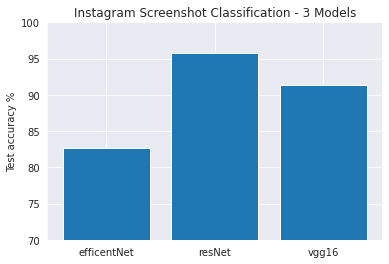

In [190]:
plt.bar(['efficentNet','resNet','vgg16'],accuracies)

plt.ylim([70,100])
plt.ylabel('Test accuracy %')
# plt.legend(loc='lower right')
plt.title('Instagram Screenshot Classification - 3 Models')
# plt.savefig('foo.png')
plt.show()



<h1>Test individual image</h1>

In [177]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(accuracy)[:str(accuracy).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    # print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    # print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

In [178]:
def classify(sdir, csv_path,  model_path, crop_image = False):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0] 
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1]) 
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    # print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)    
    index_list=[] 
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):       
        img=plt.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)            
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))           
            index=np.argmax(p)            
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0] 
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]            
            if nkey == key:
                keycount +=1                
        if keycount> most:
            most=keycount
            isave=i             
    best_index=index_list[isave]    
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]  
    img= cropped_image_list[isave]/255    
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
   
    plt.imshow(img)

    return class_name, bestsum/image_count

In [160]:
save_dir='./'
subject='instagram'
generator=train_gen
scale = 1
vgg_model_save_loc, vgg_csv_save_loc=saver(save_dir, vgg_model, 'vgg-16', subject, vgg_acc, img_size, scale,  generator)
res_model_save_loc, res_csv_save_loc=saver(save_dir, resNet_model, 'resNet50', subject, res_acc, img_size, scale,  generator)
eff_model_save_loc, eff_csv_save_loc=saver(save_dir, effNet_model, 'efficientNet', subject, eff_acc, img_size, scale,  generator)

In [161]:
working_dir  = r'./'
b_store_path=os.path.join(working_dir, 'storage/beauty')
fam_store_path=os.path.join(working_dir, 'storage/family')
fash_store_path=os.path.join(working_dir, 'storage/fashion')
fit_store_path=os.path.join(working_dir, 'storage/fitness')
food_store_path=os.path.join(working_dir, 'storage/food')

if os.path.isdir(b_store_path):
    shutil.rmtree(b_store_path)
os.mkdir(b_store_path)


if os.path.isdir(fam_store_path):
    shutil.rmtree(fam_store_path)
os.mkdir(fam_store_path)


if os.path.isdir(fash_store_path):
    shutil.rmtree(fash_store_path)
os.mkdir(fash_store_path)


if os.path.isdir(fit_store_path):
    shutil.rmtree(fit_store_path)
os.mkdir(fit_store_path)


if os.path.isdir(food_store_path):
    shutil.rmtree(food_store_path)
os.mkdir(food_store_path)

b_img_path=r'/home/jovyan/finalDeployment/instaImages/beauty/1208_sj.jpg'
fam_img_path=r'/home/jovyan/finalDeployment/instaImages/family/adambuzz.jpg'
# fam_img_path=r'/home/jovyan/finalDeployment/instaImages/family/unnamed.png'
fash_img_path=r'/home/jovyan/finalDeployment/instaImages/fashion/_azrak_.jpg'
fit_img_path=r'/home/jovyan/finalDeployment/instaImages/fitness/adbfit.jpg'
food_img_path=r'/home/jovyan/finalDeployment/instaImages/food/2cookinmamas.jpg'

b_img=cv2.imread(b_img_path)
fam_img=cv2.imread(fam_img_path)
fash_img=cv2.imread(fash_img_path)
fit_img=cv2.imread(fit_img_path)
food_img=cv2.imread(food_img_path)
# img = cv2.LoadImage("finalDeployment/instaImages/beauty/_artacha.jpg", CV_LOAD_IMAGE_COLOR)

b_file_name=os.path.split(b_img_path)[1]
fam_file_name=os.path.split(fam_img_path)[1]
fash_file_name=os.path.split(fash_img_path)[1]
fit_file_name=os.path.split(fit_img_path)[1]
food_file_name=os.path.split(food_img_path)[1]

b_dst_path=os.path.join(b_store_path, b_file_name)
fam_dst_path=os.path.join(fam_store_path, fam_file_name)
fash_dst_path=os.path.join(fash_store_path, fash_file_name)
fit_dst_path=os.path.join(fit_store_path, fit_file_name)
food_dst_path=os.path.join(food_store_path, food_file_name)

cv2.imwrite(b_dst_path, b_img)
cv2.imwrite(fam_dst_path, fam_img)
cv2.imwrite(fash_dst_path, fash_img)
cv2.imwrite(fit_dst_path, fit_img)
cv2.imwrite(food_dst_path, food_img)
# check if the directory was created and image stored
print (os.listdir(working_dir))

['.ipynb_checkpoints', 'ResNet50V2-instagram-94.15.h5', 'instaImages', 'storage', 'class_dict.csv', 'VGG16-instagram-93.03.h5', 'vgg-16-instagram-91.36.h5', 'EfficientNetB2-instagram-81.05.h5', 'resNet50-instagram-95.82.h5', 'instaDeployment.ipynb', 'testImages', 'saved-output.txt', 'efficientNet-instagram-82.72.h5']


<h1>Test 5 images with VGG16</h1>

Classifying 5 classes with VGG16 Model...


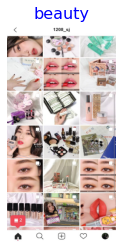

 Beauty image is classified as beauty with a probability of  100.00 %


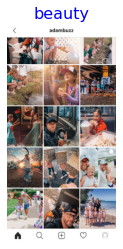

 Family image is classified as beauty with a probability of  94.37 %


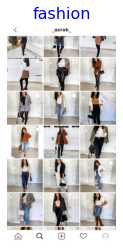

 Fashion image is classified as fashion with a probability of  57.29 %


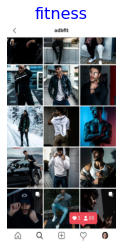

 Fitness image is classified as fitness with a probability of  99.75 %


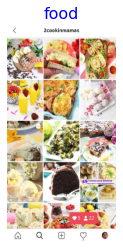

 Food image is classified as food with a probability of  88.65 %


In [180]:
vgg_csv_path=vgg_csv_save_loc # path to class_dict.csv
vgg_model_path=vgg_model_save_loc # path to the trained model
imagePaths = [b_store_path,fam_store_path,fash_store_path,fit_store_path,food_store_path]
classes = ['Beauty', 'Family', 'Fashion', 'Fitness','Food']
count = 0 
print('Classifying 5 classes with VGG16 Model...')
for imagePath in imagePaths:
    class_name, probability=classify(imagePath, vgg_csv_path,  vgg_model_path, crop_image = False) # run the classifier
    plt.show()
    msg=f' {classes[count]} image is classified as {class_name} with a probability of {probability * 100: 6.2f} %'
    count += 1
    print(msg)

<h1>Test 5 images with EfficientNet</h1>

Classifying 5 classes with EfficientNet Model...


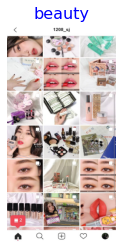

 Beauty image is classified as beauty with a probability of  100.00 %


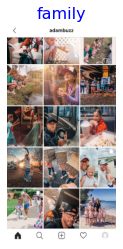

 Family image is classified as family with a probability of  51.58 %


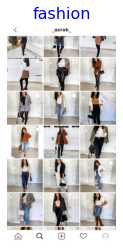

 Fashion image is classified as fashion with a probability of  85.93 %


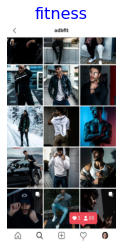

 Fitness image is classified as fitness with a probability of  96.92 %


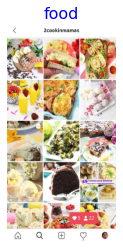

 Food image is classified as food with a probability of  89.77 %


In [182]:
eff_csv_path=eff_csv_save_loc # path to class_dict.csv
eff_model_path=eff_model_save_loc # path to the trained model
imagePaths = [b_store_path,fam_store_path,fash_store_path,fit_store_path,food_store_path]
classes = ['Beauty', 'Family', 'Fashion', 'Fitness','Food']
count = 0 
print('Classifying 5 classes with EfficientNet Model...')
for imagePath in imagePaths:
    class_name, probability=classify(imagePath, eff_csv_path,  eff_model_path, crop_image = False) # run the classifier
    plt.show()
    msg=f' {classes[count]} image is classified as {class_name} with a probability of {probability * 100: 6.2f} %'
    count += 1
    print(msg)

<h1>Test 5 images with ResNet50</h1>

Classifying 5 classes with ResNet50 Model...


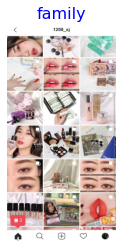

 Beauty image is classified as family with a probability of  92.93 %


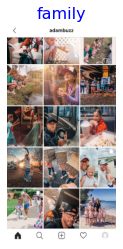

 Family image is classified as family with a probability of  86.66 %


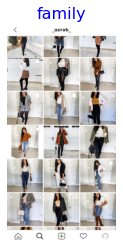

 Fashion image is classified as family with a probability of  60.36 %


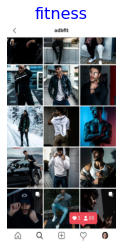

 Fitness image is classified as fitness with a probability of  92.40 %


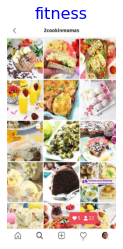

 Food image is classified as fitness with a probability of  78.11 %


In [183]:
res_csv_path=res_csv_save_loc # path to class_dict.csv
res_model_path=res_model_save_loc # path to the trained model
imagePaths = [b_store_path,fam_store_path,fash_store_path,fit_store_path,food_store_path]
classes = ['Beauty', 'Family', 'Fashion', 'Fitness','Food']
count = 0 
print('Classifying 5 classes with ResNet50 Model...')
for imagePath in imagePaths:
    class_name, probability=classify(imagePath, res_csv_path,  res_model_path, crop_image = False) # run the classifier
    plt.show()
    msg=f' {classes[count]} image is classified as {class_name} with a probability of {probability * 100: 6.2f} %'
    count += 1
    print(msg)

<h1>Test your own images. *Models seem to be leaning towards a specific classification and needs investigation*</h1>

In [184]:
# widgets.FileUpload(
#     accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
#     multiple=False  # True to accept multiple files upload else False
# )
!rm /home/jovyan/finalDeployment/testImages/*

from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [185]:
with open(r'/home/jovyan/finalDeployment/testImages/test.png', "wb") as fp:
    fp.write(upload.data[0])

In [186]:
!rm -r /home/jovyan/finalDeployment/testImages/.ipynb_checkpoints

rm: cannot remove '/home/jovyan/finalDeployment/testImages/.ipynb_checkpoints': No such file or directory


Classifying image with ResNetModel
image is classified as fashion with a probability of  86.44 %


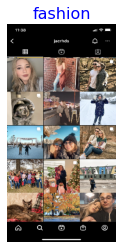

In [187]:
working_dir  = r'./'
test_img_path=os.path.join(working_dir, 'testImages')

res_csv_path=res_csv_save_loc # path to class_dict.csv
res_model_path=res_model_save_loc # path to the trained model
imagePaths = [b_store_path,fam_store_path,fash_store_path,fit_store_path,food_store_path]

print('Classifying image with ResNetModel')
class_name, probability=classify(test_img_path, res_csv_path,  res_model_path, crop_image = False) # run the classifier

msg=f'image is classified as {class_name} with a probability of {probability * 100: 6.2f} %'

print(msg)

Classifying image with EfficientNet
image is classified as fitness with a probability of  71.81 %


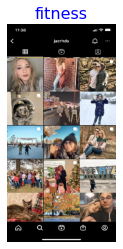

In [188]:
working_dir  = r'./'
test_img_path=os.path.join(working_dir, 'testImages')

eff_csv_path=eff_csv_save_loc # path to class_dict.csv
eff_model_path=eff_model_save_loc # path to the trained model
imagePaths = [b_store_path,fam_store_path,fash_store_path,fit_store_path,food_store_path]

print('Classifying image with EfficientNet')
class_name, probability=classify(test_img_path, eff_csv_path,  eff_model_path, crop_image = False) # run the classifier

msg=f'image is classified as {class_name} with a probability of {probability * 100: 6.2f} %'

print(msg)

Classifying image with VGG16
image is classified as family with a probability of  28.91 %


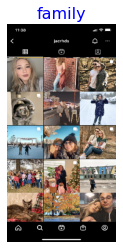

In [189]:
working_dir  = r'./'
test_img_path=os.path.join(working_dir, 'testImages')

vgg_csv_path=vgg_csv_save_loc # path to class_dict.csv
vgg_model_path=vgg_model_save_loc # path to the trained model
imagePaths = [b_store_path,fam_store_path,fash_store_path,fit_store_path,food_store_path]

print('Classifying image with VGG16')
class_name, probability=classify(test_img_path, vgg_csv_path,  vgg_model_path, crop_image = False) # run the classifier

msg=f'image is classified as {class_name} with a probability of {probability * 100: 6.2f} %'

print(msg)